In [7]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import tensorflow
import torch.utils.tensorboard

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline

import os
import copy
import sys
import pprint

In [2]:
# Our neural nets architectures.

class LeNet300_100(nn.Module):
    def __init__(self):
        super(LeNet300_100, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc_out = nn.Linear(100, 10)

    def forward(self, input):
        x = input.flatten(start_dim=1, end_dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_out(x)
        return x

class Conv_2(nn.Module):
    def __init__(self):
        super(Conv_2, self).__init__()
        self.conv11 = nn.Conv2d(3, 64, 3)
        self.conv12 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(14*14*64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_out = nn.Linear(256, 10)

    def forward(self, input_x):
        x = F.relu(self.conv11(input_x))
        x = F.relu(self.conv12(x))
        x = self.pool(x)
        x = x.view(-1, 14*14*64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_out(x)
        return x

class Conv_4(nn.Module):
    def __init__(self):
        super(Conv_4, self).__init__()
        self.conv11 = nn.Conv2d(3, 64, 3)
        self.conv12 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv21 = nn.Conv2d(64, 128, 3)
        self.conv22 = nn.Conv2d(128, 128, 3)
        self.fc1 = nn.Linear(5*5*128, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_out = nn.Linear(256, 10)

    def forward(self, input_x):
        x = F.relu(self.conv11(input_x))
        x = F.relu(self.conv12(x))
        x = self.pool(x)
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.pool(x)
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_out(x)
        return x

In [37]:
def get_stats_snip(experiment_name):
    xpd = {}
    for i in range(1, 11):
        xpd[i] = {}
        xpd[i]['best_test_accs'] = np.load(experiment_name + '_' + str(i) + '/best_test_accs.npy')
        xpd[i]['best_test_loss'] = np.load(experiment_name + '_' + str(i) +'/best_test_losses.npy')
        xpd[i]['best_train_accs'] = np.load(experiment_name + '_' + str(i) +'/best_train_accs.npy')
        xpd[i]['best_train_loss'] = np.load(experiment_name + '_' + str(i) +'/best_train_losses.npy')
        xpd[i]['best_valid_accs'] = np.load(experiment_name + '_' + str(i) +'/best_valid_accs.npy')
        xpd[i]['best_valid_loss'] = np.load(experiment_name + '_' + str(i) +'/best_valid_losses.npy')
        xpd[i]['unpruned_weights_counts'] = np.load(experiment_name + '_' + str(i) +'/unpruned_weights_counts.npy')
        xpd[i]['early_stop_iterations'] = np.load(experiment_name + '_' + str(i) +'/early_stop_iterations.npy')
        xpd[i]['test_accs'] = np.load(experiment_name + '_' + str(i) +'/stats/test_accs.npy')
        xpd[i]['test_loss'] = np.load(experiment_name + '_' + str(i) +'/stats/test_losses.npy')
        xpd[i]['train_accs'] = np.load(experiment_name + '_' + str(i) +'/stats/train_accs.npy')
        xpd[i]['train_loss'] = np.load(experiment_name + '_' + str(i) +'/stats/train_losses.npy')
        xpd[i]['valid_accs'] = np.load(experiment_name + '_' + str(i) +'/stats/valid_accs.npy')
        xpd[i]['valid_loss'] = np.load(experiment_name + '_' + str(i) +'/stats/valid_losses.npy')
    
    return xpd

def get_stats_lth(experiment_name):
    xpd = {}
    xpd['best_test_accs'] = np.load(experiment_name + '/best_test_accs.npy')
    xpd['best_test_loss'] = np.load(experiment_name + '/best_test_losses.npy')
    xpd['best_train_accs'] = np.load(experiment_name + '/best_train_accs.npy')
    xpd['best_train_loss'] = np.load(experiment_name + '/best_train_losses.npy')
    xpd['best_valid_accs'] = np.load(experiment_name + '/best_valid_accs.npy')
    xpd['best_valid_loss'] = np.load(experiment_name + '/best_valid_losses.npy')
    xpd['unpruned_weights_counts'] = np.load(experiment_name + '/unpruned_weights_counts.npy')
    xpd['early_stop_iterations'] = np.load(experiment_name + '/early_stop_iterations.npy')
    for i in range(0, 11):
        xpd[i] = {}
        xpd[i]['test_accs'] = np.load(experiment_name + '/stats/test_accs_' + str(i) + '.npy')
        xpd[i]['test_loss'] = np.load(experiment_name + '/stats/test_losses_' + str(i) + '.npy')
        xpd[i]['train_accs'] = np.load(experiment_name + '/stats/train_accs_' + str(i) + '.npy')
        xpd[i]['train_loss'] = np.load(experiment_name + '/stats/train_losses_' + str(i) + '.npy')
        xpd[i]['valid_accs'] = np.load(experiment_name + '/stats/valid_accs_' + str(i) + '.npy')
        xpd[i]['valid_loss'] = np.load(experiment_name + '/stats/valid_losses_' + str(i) + '.npy')
    
    return xpd

def get_stats_lthf(experiment_name, iterations):
    xpd = {}
    xpd['best_test_accs'] = np.load(experiment_name + '/best_test_accs.npy')
    xpd['best_test_loss'] = np.load(experiment_name + '/best_test_losses.npy')
    xpd['best_train_accs'] = np.load(experiment_name + '/best_train_accs.npy')
    xpd['best_train_loss'] = np.load(experiment_name + '/best_train_losses.npy')
    xpd['best_valid_accs'] = np.load(experiment_name + '/best_valid_accs.npy')
    xpd['best_valid_loss'] = np.load(experiment_name + '/best_valid_losses.npy')
    xpd['unpruned_weights_counts'] = np.load(experiment_name + '/unpruned_weights_counts.npy')
    xpd['early_stop_iterations'] = np.load(experiment_name + '/early_stop_iterations.npy')
    for i in range(0, iterations+1):
        xpd[i] = {}
        xpd[i]['test_accs'] = np.load(experiment_name + '/stats/test_accs_' + str(i) + '.npy')
        xpd[i]['test_loss'] = np.load(experiment_name + '/stats/test_losses_' + str(i) + '.npy')
        xpd[i]['train_accs'] = np.load(experiment_name + '/stats/train_accs_' + str(i) + '.npy')
        xpd[i]['train_loss'] = np.load(experiment_name + '/stats/train_losses_' + str(i) + '.npy')
        xpd[i]['valid_accs'] = np.load(experiment_name + '/stats/valid_accs_' + str(i) + '.npy')
        xpd[i]['valid_loss'] = np.load(experiment_name + '/stats/valid_losses_' + str(i) + '.npy')
    
    return xpd

In [38]:
get_stats_lthf('lthf_fc1_260220_1_7', 9)

{'best_test_accs': array([97.95180723, 97.73092369, 97.82128514, 97.87148594, 98.062249  ,
        98.28313253, 98.09236948, 98.07228916, 98.1626506 , 98.10240964]),
 'best_test_loss': array([0.07529425, 0.07594151, 0.07584871, 0.08413245, 0.06982806,
        0.08280532, 0.06534498, 0.06214004, 0.06841203, 0.07943933]),
 'best_train_accs': array([99.51965066, 99.24308588, 98.6444687 , 99.66339156, 99.64701601,
        99.90720524, 99.74526929, 99.7507278 , 99.90902475, 99.96179039]),
 'best_train_loss': array([0.01503068, 0.02310106, 0.04362265, 0.01133577, 0.0110166 ,
        0.00352525, 0.01001787, 0.01131759, 0.00483655, 0.00282983]),
 'best_valid_accs': array([98.05220884, 98.03212851, 97.48995984, 98.03212851, 97.97188755,
        98.21285141, 98.17269076, 98.37349398, 98.41365462, 98.19277108]),
 'best_valid_loss': array([0.07914671, 0.07927087, 0.08608249, 0.09751858, 0.07684611,
        0.09098778, 0.0706733 , 0.06539685, 0.07201177, 0.08595531]),
 'unpruned_weights_counts': ar

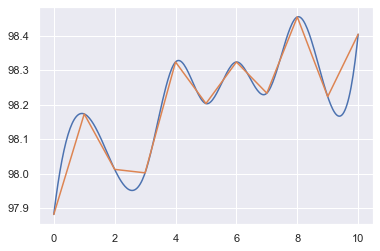

In [4]:
lthfc1_0 = experiment_dict['lth_fc1_230220_0']
lthfc1_1 = experiment_dict['lth_fc1_230220_1']
lthc2_0 = experiment_dict['lth_conv2_240220_0']
lthc2_1 = experiment_dict['lth_conv2_240220_1']
iter_nr = np.arange(0., 11., 1.)

xnew = np.linspace(iter_nr.min(), iter_nr.max(), 300)
spl = make_interp_spline(iter_nr, lthfc1_0['test_accs'], k = 3)
power_smooth = spl(xnew)

sns.set()
ax = sns.lineplot(x=xnew, y=power_smooth)
ax = sns.lineplot(x=iter_nr, y=lthfc1_0['test_accs'])

In [85]:
model1 = torch.load('lth_fc1_230220_0/best_model_prune_iteration_10.pth')
model2 = torch.load('lthf_fc1_250220_0/best_model_prune_iteration_5.pth')

C:\Users\isvladu\Anaconda3\lib\site-packages\torch\serialization.py:559: UserWarning: Couldn't retrieve source code for container of type LeNet300_100. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [90]:
calculate_overlap_SNIP_LTH(model1, model2)

{'diff12': [25254, 3221, 348],
 'diff21': [68795, 8774, 384],
 'overlap': [0, 0, 0],
 'kept1': [25254, 3221, 348],
 'kept2': [68795, 8774, 384]}

In [89]:
def calculate_overlap_SNIP_LTH(model1, model2):
    diff12 = []
    diff21 = []
    overlap = []
    kept1 = []
    kept2 = []
    
    # Calculating number of weights kept in model1.
    for n1, module1 in model1.named_modules():
        if isinstance(module1, torch.nn.Linear) or isinstance(module1, torch.nn.Conv2d):
            kept1.append(int(module1.weight_mask.sum().item()))
            
    # Calculating number of weights kept in model2.        
    for n2, module2 in model2.named_modules():
        if isinstance(module2, torch.nn.Linear) or isinstance(module2, torch.nn.Conv2d):
            kept2.append(int(module2.weight_mask.sum().item()))
    
    # Calculating diff 1-2, diff 2-1 and overlap.
    for module_name, module in model1.named_modules():
        if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d):
            weight_mask_module1 = getattr(model1, module_name).weight_mask
            weight_mask_module2 = getattr(model2, module_name).weight_mask
            diff = weight_mask_module1 - weight_mask_module2
            product = weight_mask_module1 * weight_mask_module2
            diff1_2 = weight_mask_module1 - product
            diff2_1 = weight_mask_module2 - product
            diff12.append(int(diff1_2.sum().item()))
            diff21.append(int(diff2_1.sum().item()))
            overlap.append(int(product.sum().item()))
                                   
    return {'diff12': diff12, 'diff21': diff21, 'overlap': overlap, 'kept1': kept1, 'kept2': kept2}

In [15]:
test = np.load('lth_conv2_260220_0/stats/test_accs_2.npy')
list(range(1,11))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [81]:
a = torch.Tensor([[1., 0., 0., 0.], [0., 0., 1., 1.], [1., 1., 1., 1.], [0., 1., 1., 0.]])
b = torch.Tensor([[1., 0., 1., 0.], [0., 0., 0., 1.], [1., 1., 0., 1.], [1., 1., 1., 0.]])

x = torch.tensor(24890., device='cuda:0') 
int(x.item())

24890